In [1]:
import numpy as np

from casq import PulseBackendProperties, PulseOptimizer, PulseSimulator
from casq.circuit import PulseCircuit
from casq.common import initialize_jax

initialize_jax()


In [2]:
backend_props = PulseBackendProperties("ibmq_manila")
simulator = PulseSimulator.from_backend(
    backend="ibmq_manila", qubits=[0], steps=100,
    method=PulseSimulator.ODESolverMethod.SCIPY_DOP853
)
simulator_jax=PulseSimulator.from_backend(
    backend="ibmq_manila", qubits=[0],
    method=PulseSimulator.ODESolverMethod.QISKIT_DYNAMICS_JAX_ODEINT,
    solver_options={"atol": 1e-6, "rtol": 1e-8, "hmax": backend_props.dt}
)
optimizer = PulseOptimizer(
    pulse_type=PulseOptimizer.PulseType.GAUSSIAN_SQUARE,
    pulse_arguments={
        "duration": 230, "amplitude": 1, "name": "x",
        "sigma": None, "width": None
    },
    simulator=simulator,
    target_measurement={"0": 0, "1": 1024},
    fidelity_type=PulseOptimizer.FidelityType.COUNTS,
    target_qubit=0, use_jax=False, use_jit=False
)
optimizer_jax = PulseOptimizer(
    pulse_type=PulseOptimizer.PulseType.GAUSSIAN_SQUARE,
    pulse_arguments={
        "duration": 230, "amplitude": 1, "name": "x",
        "sigma": None, "width": None
    },
    simulator=simulator_jax,
    target_measurement={"0": 0, "1": 1024},
    fidelity_type=PulseOptimizer.FidelityType.COUNTS,
    target_qubit=0, use_jax=True, use_jit=False
)


2023-07-03 09:18:43.026 | DEBUG    | casq.pulse_optimizer:_build_pulse_function:246 - Building pulse with parameters = ['sigma', 'width'] and fixed arguments = {'duration': 230, 'amplitude': 1, 'name': 'x', 'jax': False}
2023-07-03 09:18:43.028 | DEBUG    | casq.pulse_optimizer:_build_pulse_function:246 - Building pulse with parameters = ['sigma', 'width'] and fixed arguments = {'duration': 230, 'amplitude': 1, 'name': 'x', 'jax': True}


In [3]:
initial_params = np.array([10.0, 10.0])
pulse_gate = optimizer_jax.pulse_function(initial_params)
circuit = PulseCircuit.from_pulse(pulse_gate, backend_props.backend, 0)


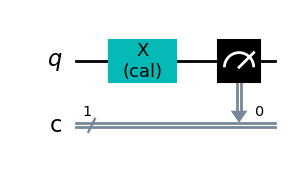

In [4]:
circuit.draw("mpl")

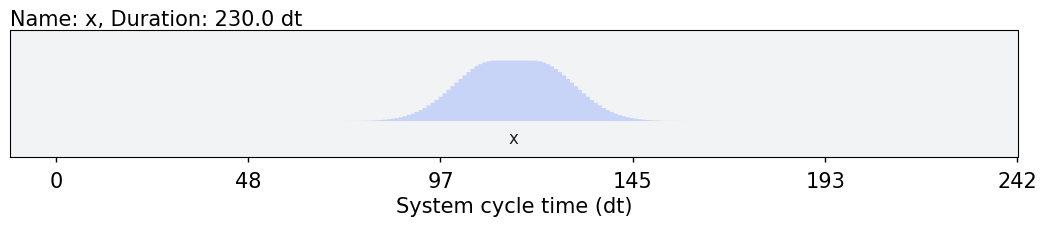

In [5]:
pulse_gate.pulse().draw()

In [6]:
%%time
optimizer.objective_function(initial_params)


2023-07-03 09:19:08.207 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10. 10.] TARGET: {'0': 881, '1': 143} OBJECTIVE: 0.8603515625


CPU times: user 24.4 s, sys: 194 ms, total: 24.6 s
Wall time: 24.7 s


0.8603515625

In [7]:
%%time
optimizer_jax.objective_function(initial_params)


2023-07-03 09:19:09.191 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10. 10.] TARGET: {'0': 831, '1': 193} OBJECTIVE: 0.8115234375


CPU times: user 950 ms, sys: 42.9 ms, total: 993 ms
Wall time: 978 ms


0.8115234375

In [8]:
%%time
solution = optimizer_jax.optimize(
    initial_params, method=PulseOptimizer.OptimizationMethod.SCIPY_NELDER_MEAD, tol=1e-2
)
print("================================================================================")
print("OPTIMIZED PULSE")
print("================================================================================")
print(f"ITERATIONS: {solution.num_iterations}")
print(f"OPTIMIZED PARAMETERS: {solution.parameters}")
print(f"MEASUREMENT: {solution.measurement}")
print(f"FIDELITY: {solution.fidelity}")
print(f"MESSAGE: {solution.message}")
print("================================================================================")


2023-07-03 09:19:09.990 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10. 10.] TARGET: {'0': 860, '1': 164} OBJECTIVE: 0.8398437499999999
2023-07-03 09:19:10.813 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.5 10. ] TARGET: {'0': 747, '1': 277} OBJECTIVE: 0.7294921874999999
2023-07-03 09:19:11.551 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.  10.5] TARGET: {'0': 814, '1': 210} OBJECTIVE: 0.7949218750000001
2023-07-03 09:19:12.270 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.5 10.5] TARGET: {'0': 696, '1': 328} OBJECTIVE: 0.6796875
2023-07-03 09:19:13.022 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [10.75 10.75] TARGET: {'0': 629, '1': 395} OBJECTIVE: 0.6142578125000001
2023-07-03 09:19:13.755 | DEBUG    | casq.pulse_optimizer:objective:222 - PARAMETERS: [11.25 10.25] TARGET: {'0': 560, '1': 464} OBJECTIVE: 0.546875
2023-07-03 09:19:14.602 | DEBUG    | casq.pulse_optimizer:objective:222 - P

Optimization terminated successfully.
         Current function value: 0.003906
         Iterations: 18
         Function evaluations: 46
OPTIMIZED PULSE
ITERATIONS: 46
OPTIMIZED PARAMETERS: [14.56246948 10.52481079]
MEASUREMENT: {'0': 10, '1': 1014}
FIDELITY: 0.9960937499999999
MESSAGE: Optimization terminated successfully.
CPU times: user 33 s, sys: 1.6 s, total: 34.6 s
Wall time: 33.9 s


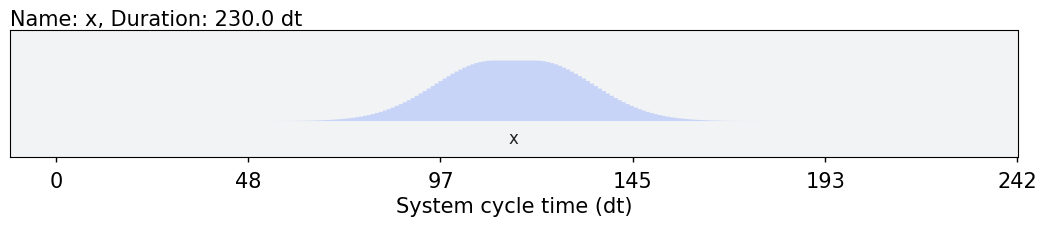

In [9]:
solution.gate.pulse().draw()
